In [1]:
import librosa as lb
import librosa.display
import pandas as pd
import scipy
import json
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
from pylab import plot, show, figure, imshow, xlim, ylim, title
import matplotlib.pyplot as plt
import keras
from keras.utils import np_utils
from keras import layers
from keras import models

Using TensorFlow backend.


In [2]:
#CONSTANTS

DATA_DIR = "openmic-2018/"
CATEGORY_COUNT = 8

In [3]:
df = pd.read_csv('openmic-2018/openmic-2018-aggregated-labels.csv')
del df['relevance']
del df['num_responses']

In [4]:
labels = df.values
labels

array([['000046_3840', 'clarinet'],
       ['000046_3840', 'flute'],
       ['000046_3840', 'trumpet'],
       ...,
       ['155311_453120', 'saxophone'],
       ['155311_453120', 'trumpet'],
       ['155311_453120', 'trombone']], dtype=object)

In [5]:
y, sr = lb.load(DATA_DIR + 'audio/000/000135_483840.ogg')
S = lb.feature.melspectrogram(y=y, sr=sr)

S_dB = lb.power_to_db(S, ref=0) # 10 * log10(S / ref)


print(y.shape)
print(sr)
print(S.shape)
print(S_dB.shape)

(220544,)
22050
(128, 431)
(128, 431)


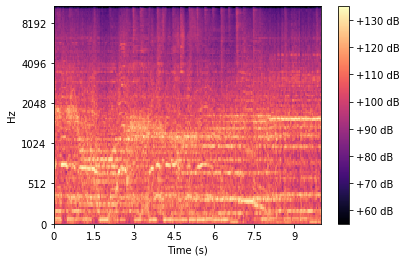

In [6]:
librosa.display.specshow(S_dB, x_axis='s', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [7]:
OPENMIC = np.load(os.path.join(DATA_DIR, 'openmic-2018.npz'), allow_pickle=True)
print(list(OPENMIC.keys()))

['X', 'Y_true', 'Y_mask', 'sample_key']


In [8]:
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']
#print(X.shape)
#X = []
#print(len(sample_key))
#for key in sample_key:
#    key_dir = key[:3]
#    y, sr = lb.load(DATA_DIR + 'audio/'+ key_dir + '/' + key + '.ogg')
#    X.append(lb.feature.melspectrogram(y=y, sr=sr))
#    print(len(X))

In [9]:
with open(os.path.join(DATA_DIR, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [10]:
split_train, split_test, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test = train_test_split(sample_key, X, Y_true, Y_mask)
train_set = np.asarray(set(split_train))
test_set = np.asarray(set(split_test))
print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

# Train: 15000,  # Test: 5000


In [11]:
print(X_train.shape)
print(X_test.shape)

(15000, 10, 128)
(5000, 10, 128)


In [13]:
# This dictionary will include the classifiers for each model
mymodels = dict()

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_map:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
        
    # Step 1: sub-sample the data
    
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Step 3: simplify the data by averaging over time
    
    # Let's arrange the data for a sklearn Random Forest model 
    # Instead of having time-varying features, we'll summarize each track by its mean feature vector over time
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5

    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    
    X_train_inst = X_train_inst.astype('float32')
    X_train_inst_sklearn = X_train_inst_sklearn.astype('float32')
    X_train_inst_sklearn = lb.util.normalize(X_train_inst_sklearn)
   # X_train_inst = S_dB
    print(X_train_inst.shape)
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    #X_train_inst = X_train_inst.reshape(1,1,431,128)
    print(X_train_inst.shape)
    print(Y_true_train_inst[0])
    # Step 3.
    # Initialize a new classifier
    import keras,os
    from keras.models import Sequential
    from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
    from keras.preprocessing.image import ImageDataGenerator
    import numpy as np
    model = models.Sequential()

    # model.add(layers.Conv2D(filters=8,kernel_size=(3,3),activation='relu', input_shape=(10,128,1,)))
    model.add(Conv2D(input_shape=(1,10,128),data_format="channels_first",filters=32,kernel_size=(3,3),padding="same", activation="relu",strides=(2,2)))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu",strides=(2,2)))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=256, activation='relu'))
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['acc'])
    
   # model.summary()
    # Step 4.
    model.fit(X_train_inst,Y_true_train_inst , epochs=10, batch_size=64) 

    # Step 5.
    # Finally, we'll evaluate the model on both train and test
    Y_pred_train = model.predict(X_train_inst)
    Y_pred_test = model.predict(X_test_inst)
    Y_pred_train_bool = Y_pred_train > 0.3 #THRESHOLD (should be lower than 0.5)
    Y_pred_test_bool = Y_pred_test > 0.3 #THRESHOLD (should be lower than 0.5)
    print(Y_pred_train[0])
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train_bool))

    print(Y_true_train_inst[3])
    print(Y_pred_train[3])
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_bool))
    sum = 0
  #  for i, prob in enumerate(Y_pred_train):
  #      print (i)
  #      print (prob)
  #      sum += prob
  #  print(sum)
    # Store the classifier in our dictionary
    mymodels[instrument] = model




(1539, 10, 128)
(1539, 1, 10, 128)
False
Epoch 1/10
1539/1539 [==============================] - 4s 2ms/step - loss: 0.8286 - acc: 0.7057
Epoch 2/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.5063 - acc: 0.7661
Epoch 3/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4889 - acc: 0.7810
Epoch 4/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.4506 - acc: 0.7888
Epoch 5/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.3925 - acc: 0.8109
Epoch 6/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.3575 - acc: 0.8395
Epoch 7/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.3421 - acc: 0.8447
Epoch 8/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.3203 - acc: 0.8545A: 1s - los
Epoch 9/10
1539/1539 [==============================] - 2s 1ms/step - loss: 0.2954 - acc: 0.8824
Epoch 10/10
1539/1539 [==============================] - 2s 1ms/step - loss

1345/1345 [==============================] - 2s 1ms/step - loss: 0.4930 - acc: 0.7279
Epoch 3/10
1345/1345 [==============================] - 3s 2ms/step - loss: 0.4327 - acc: 0.7948
Epoch 4/10
1345/1345 [==============================] - 2s 2ms/step - loss: 0.3678 - acc: 0.8320
Epoch 5/10
1345/1345 [==============================] - 3s 2ms/step - loss: 0.3244 - acc: 0.8506
Epoch 6/10
1345/1345 [==============================] - 2s 1ms/step - loss: 0.3129 - acc: 0.8572A: 1s - loss: 0.
Epoch 7/10
1345/1345 [==============================] - 2s 1ms/step - loss: 0.3694 - acc: 0.8409
Epoch 8/10
1345/1345 [==============================] - 2s 2ms/step - loss: 0.2657 - acc: 0.8914
Epoch 9/10
1345/1345 [==============================] - 2s 2ms/step - loss: 0.1968 - acc: 0.9197
Epoch 10/10
1345/1345 [==============================] - 2s 1ms/step - loss: 0.1436 - acc: 0.9532
[0.93632215]
----------------------------------------------------
mallet_percussion
	TRAIN
              precision    rec

Epoch 1/10
1185/1185 [==============================] - 4s 4ms/step - loss: 0.6299 - acc: 0.7840
Epoch 2/10
1185/1185 [==============================] - 2s 1ms/step - loss: 0.2077 - acc: 0.9367
Epoch 3/10
1185/1185 [==============================] - 1s 1ms/step - loss: 0.1712 - acc: 0.9426
Epoch 4/10
1185/1185 [==============================] - 1s 1ms/step - loss: 0.1402 - acc: 0.9603
Epoch 5/10
1185/1185 [==============================] - 1s 1ms/step - loss: 0.1054 - acc: 0.9705
Epoch 6/10
1185/1185 [==============================] - 2s 2ms/step - loss: 0.1158 - acc: 0.9654
Epoch 7/10
1185/1185 [==============================] - 2s 2ms/step - loss: 0.0950 - acc: 0.9738
Epoch 8/10
1185/1185 [==============================] - 3s 2ms/step - loss: 0.0810 - acc: 0.9806
Epoch 9/10
1185/1185 [==============================] - 2s 1ms/step - loss: 0.0653 - acc: 0.9865
Epoch 10/10
1185/1185 [==============================] - 1s 1ms/step - loss: 0.0575 - acc: 0.9831
[7.897615e-06]
--------------

Epoch 1/10
1188/1188 [==============================] - 8s 7ms/step - loss: 0.9186 - acc: 0.6490
Epoch 2/10
1188/1188 [==============================] - 2s 1ms/step - loss: 0.3191 - acc: 0.8847
Epoch 3/10
1188/1188 [==============================] - 2s 1ms/step - loss: 0.2256 - acc: 0.9234
Epoch 4/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.1700 - acc: 0.9411
Epoch 5/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.1404 - acc: 0.9529
Epoch 6/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.1197 - acc: 0.9562
Epoch 7/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0945 - acc: 0.9621
Epoch 8/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.1684 - acc: 0.9402
Epoch 9/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0842 - acc: 0.9722
Epoch 10/10
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0437 - acc: 0.9857
[1.1444092e-05]
-------------

In [ ]:
print(X_train_inst_sklearn)
print(Y_pred_train)